```{contents}
:local:
:depth: 2
```

# Complexity Optimization

## Learning objectives

By the end of this topic, you will be able to:

- **Compute and interpret information criteria** (BIC, AIC) to select model complexity for parametric models.
- **Apply regularization** (ridge/L2 and LASSO/L1) to control model smoothness and promote sparsity.
- **Tune hyperparameters** with `GridSearchCV` and design sensible grids (coarse-to-fine, avoid edge optima).
- **Detect and prevent data leakage** by separating training, validation, and test sets appropriately.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

## Overfitting and Underfitting

The key to machine learning is creating models that generalize to new examples. This means we are looking for models with enough complexity to describe the behavior, but not so much complexity that it just reproduces the data points. Let's demonstrate this concept with a quick toy model:

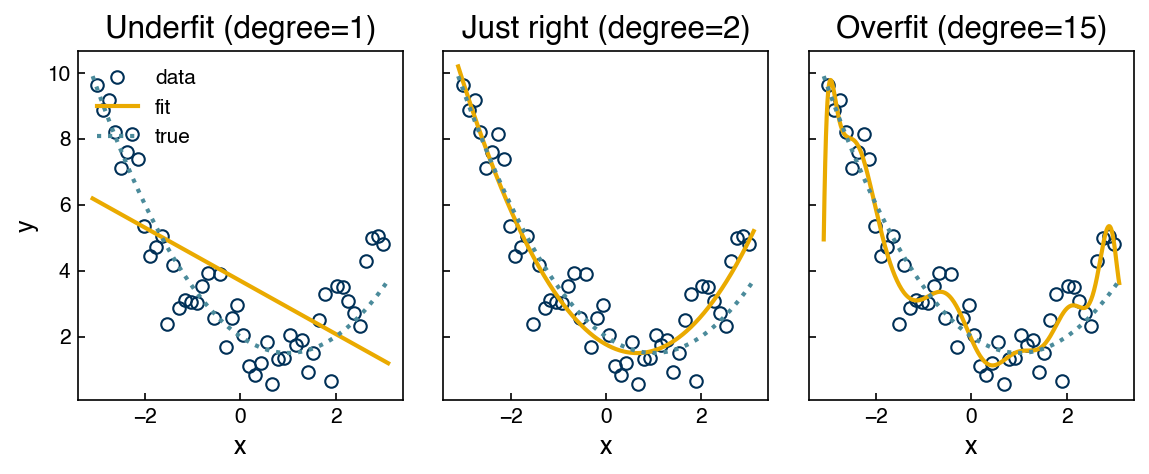

In [2]:
import numpy as np

#generate some synthetic data
rng = np.random.default_rng(0)
n = 50
x = np.linspace(-3, 3, n)
y_true = 2 - x + 0.5*x**2
y = y_true + rng.normal(scale=1.0, size=n)

xg = np.linspace(x.min()-0.1, x.max()+0.1, 400)  # grid for smooth curves

#helper function to fit and plot curves
def fit_plot(ax, x, y, deg, title):
    c = np.polyfit(x, y, deg)         
    y_fit = np.polyval(c, xg)
    ax.plot(x, y, 'o', mfc='none', label='data')
    ax.plot(xg, y_fit, '-', label='fit')
    ax.plot(xg, 2 - xg + 0.5*xg**2, ':', label='true')
    ax.set_title(title)
    ax.set_xlabel('x')

fig, axes = plt.subplots(1, 3, figsize=(8, 3.5), sharey=True)
titles = ['Underfit (degree=1)', 'Just right (degree=2)', 'Overfit (degree=15)']
degrees = [1, 2, 15]
for ax, deg, title in zip(axes, degrees, titles):
    fit_plot(ax, x, y, deg, title)

axes[0].set_ylabel('y')
axes[0].legend(loc='upper left', frameon=False)
fig.tight_layout()

* Underfitting: The model is just "guessing" at the data, and will be equally bad at the data it has been trained on and the data that it is tested on.

* Overfitting: The model has memorized all of the training data, and will be perfect on training data and terrible on testing data.

* Optimal complexity: The model has *learned* from the training data and can *generalize* to the training data. The performance should be approximately as good for both sets.

There is a famous quote about fitting models that is often used to criticize models that are "overfit" (i.e. models with too many parameters):
 
><em>"With four parameters I can fit an elephant, and with five I can make him wiggle his trunk."</em> <br/>
> \- John von Neumann \-
 
There is even a [fun example](https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/)) showing that you really can fit an elephant with four parameters! That said, despite his genius, von Neumann's quote is only half of the truth. As we will see, there is a real danger of "overfitting" models, but if we are careful and use techniques for *complexity optimization* we can end up with meaningful models with far more than 4 parameters. Modern large languge models have hundreds of millions or even billions of parameters, but they are still widely considered useful. This is also related to the philosophical principle of "Occam's Razor", which, broadly speaking, states that "the simplest explanation is usually correct". The less well known "Epicurean principle of multiple explanations" is the opposing philosophy which, broadly speaking, states that "if multiple explanations can account for a phenomenon, then all are considered plausible". Complexity optimization seeks to turn these philosophical ideas into quantitative metrics that can find the optimum balance between the two perspectives.

---

In this section, we will explore a few strategies for quantifying and optimizing model complexity. To start with, consider the general form of a machine-learning model introduced earlier:

$\vec{y} = f(\vec{x}, \vec{w}(\vec{\eta}))$
 
The "complexity" of a model is defined by its hyperparameters ($\vec{\eta}$). The goal of machine learning is to **optimize the complexity** of a model so that it **generalizes to new examples**. In order to achieve this goal we first need a way to quantify complexity so that we can optimize it.
 
In general there are a few strategies:
 
* Number of parameters: "Complexity" varies linearly with number of parameters
* Information criteria: "Complexity" varies with number of parameters and is balanced by the model error.
* "Smoothness": "Complexity" is related to the maximum curvature of the model

We will describe these approaches and show examples of how to use them to optimize complexity below.

```{admonition} Exercise:
:class: tip

Modify the code that is used to generate the ``underfitting vs. overfitting'' example above to calculate the $r^2$ score for each example. Consider whether it is possible to determine whether a model is underfit or overfit using the $r^2$ score alone.

```

## Information Criteria

The idea behind an **information criterion** is that it quantifies the trade-off between the number of parameters and the model error.  The most commonly used information criterion is the **Bayesian Information Criterion** (BIC).  The derivation of the BIC is beyond the scope of this course, but conceptually a lower BIC corresponds to a *more* probable model.

If we assume that our error is normally distributed, the BIC can be easily computed as

$$\mathrm{BIC}=n\,\ln\!\left(\sigma_e^2\right)+k\,\ln n$$

where $n$ is the number of data points, $\sigma_e$ is the standard deviation of the error, and $k$ is the number of parameters.

There are a few other information criteria, with the **Akaike Information Criterion (AIC)** being the other most commonly used.  **AIC** is [derived from a slightly different set of statistical assumptions](	https://doi.org/10.1109/TAC.1974.1100705) than BIC; many more criteria exist in the statistical literature.

In practice it is often difficult to verify whether a particular dataset satisfies the assumptions required by any given criterion, so practitioners commonly default to BIC.  These criteria should therefore be viewed as heuristics rather than absolute rules—use them to guide your intuition, but do not ignore domain knowledge or common-sense checks.

Another important limitation is that non-parametric models do not have a fixed, well-defined set of parameters; the effective parameters (and even their number) depend on the training data.  As a result, information criteria are awkward—sometimes impossible—to apply to non-parametric models.

Despite these caveats, the overarching idea of **trading off the number of parameters against model error** provides a powerful mental framework for thinking about complexity optimisation.  In the examples below we will focus on BIC (AIC usually selects a similar optimum).


Throughout this topic we will use the following helper function that computes the BIC (under the assumption of normally distributed homoskedastic error).

In [3]:
import numpy as np

def BIC(y, yhat, k):
    """Compute the Bayesian information criterion.

    Parameters
    ----------
    y : array_like
        Observed values.
    yhat : array_like
        Model predictions (same shape as *y*).
    k : int
        Number of parameters in the model.
    """

    err = np.asarray(y) - np.asarray(yhat)
    sigma = np.std(np.real(err))
    n = len(y)
    return n * np.log(sigma**2) + k * np.log(n)

Next, we can apply the BIC to the problem of fitting the ethanol spectra that we have seen in prior lectures:

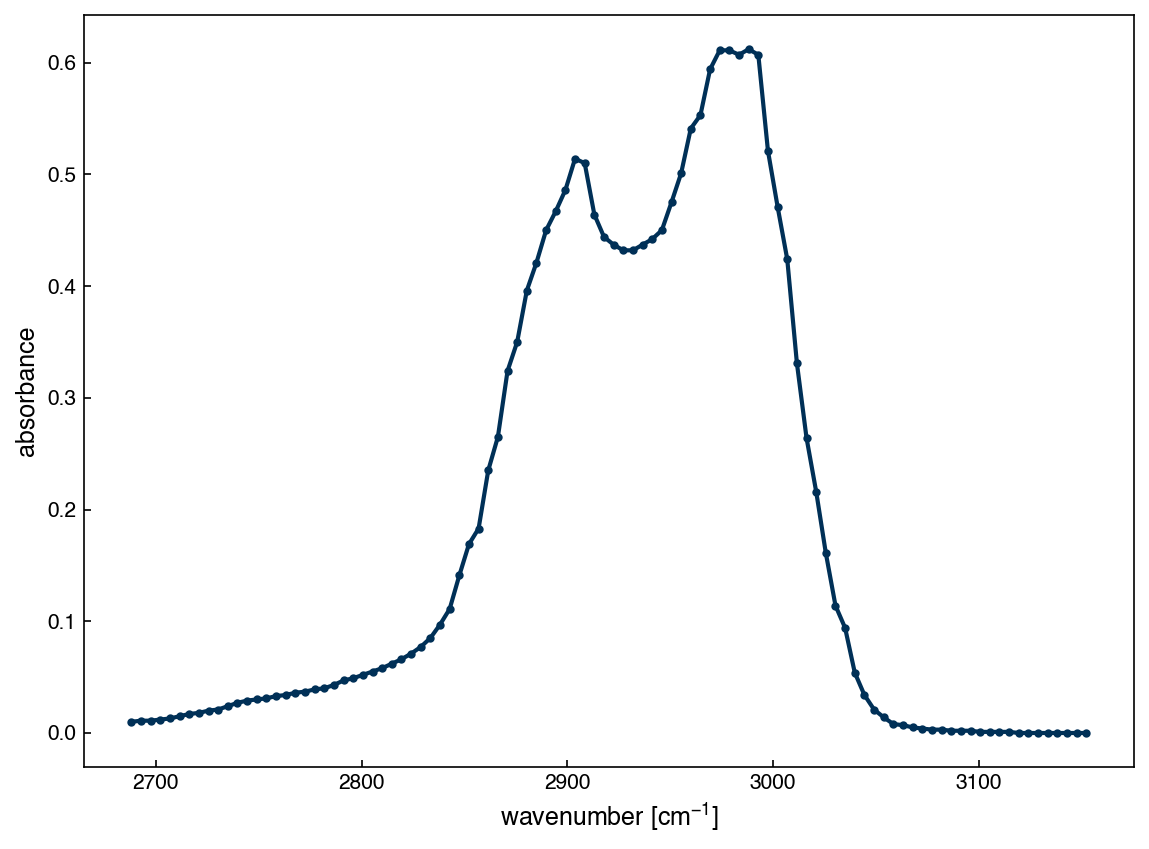

In [4]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/ethanol_IR.csv')
x_all = df['wavenumber [cm^-1]'].values
y_all = df['absorbance'].values

x_peak = x_all[475:575]
y_peak = y_all[475:575]

fig, ax = plt.subplots()
ax.plot(x_peak,y_peak, '-', marker='.')
ax.set_xlabel('wavenumber [cm$^{-1}$]')
ax.set_ylabel('absorbance');

Now, let's compare some of the many different models we have used for modeling the spectrum from the previous module and this module. We will look at the following models:

* Polynomial regression with 40 polynomials (40 parameters)
* Gaussian regression 20 evenly-spaced Gaussians (20 parameters)

We will re-implement the polynomial and Gaussian regressions using `scikit-learn` to make things easier:

In [5]:
from sklearn.linear_model import LinearRegression

def polynomial_features(x, degree):
    """Columns [x^1, x^2, ..., x^degree]. Intercept handled via fit_intercept=False."""
    x = np.asarray(x, dtype=float).ravel()
    # Vandermonde with increasing powers; drop the bias column
    # The Vandermonde polynomials are generally more numerically stable.
    return np.vander(x, degree + 1, increasing=True)[:, 1:]

# Polynomial regression: 40 polynomials (40 parameters)
N = 40
X_poly = polynomial_features(x_peak, N)
y = np.asarray(y_peak, dtype=float).ravel()

LR_poly = LinearRegression(fit_intercept=False).fit(X_poly, y)
yhat_poly = LR_poly.predict(X_poly)

BIC_poly = BIC(y, yhat_poly, N)  # N params (no intercept)
print(f"BIC (polynomial, N={N}) = {BIC_poly:.3f}")

BIC (polynomial, N=40) = -244.673


In [6]:
def gaussian_features(x, N, sigma=25.0):
    """Gaussian features with N evenly spaced centers across x's range."""
    x = np.asarray(x, dtype=float).ravel()
    centers = np.linspace(x.min(), x.max(), N)
    d2 = (x[:, None] - centers[None, :])**2               # (n_samples, N)
    return np.exp(-0.5 * d2 / (sigma**2))

# Gaussian regression: 20 Gaussians (20 parameters)
N = 20
X_gauss = gaussian_features(x_peak, N, sigma=25.0)
y = np.asarray(y_peak, dtype=float).ravel()

LR_gauss = LinearRegression(fit_intercept=False).fit(X_gauss, y)
yhat_gauss = LR_gauss.predict(X_gauss)

BIC_gauss = BIC(y, yhat_gauss, N)  # N params (no intercept)
print(f"BIC (gaussian, N={N}) = {BIC_gauss:.3f}")

BIC (gaussian, N=20) = -895.704


The BIC is lower for the Gaussian model, which suggests that it is a better fit. Let's visualize to see if this aligns with our intuition:

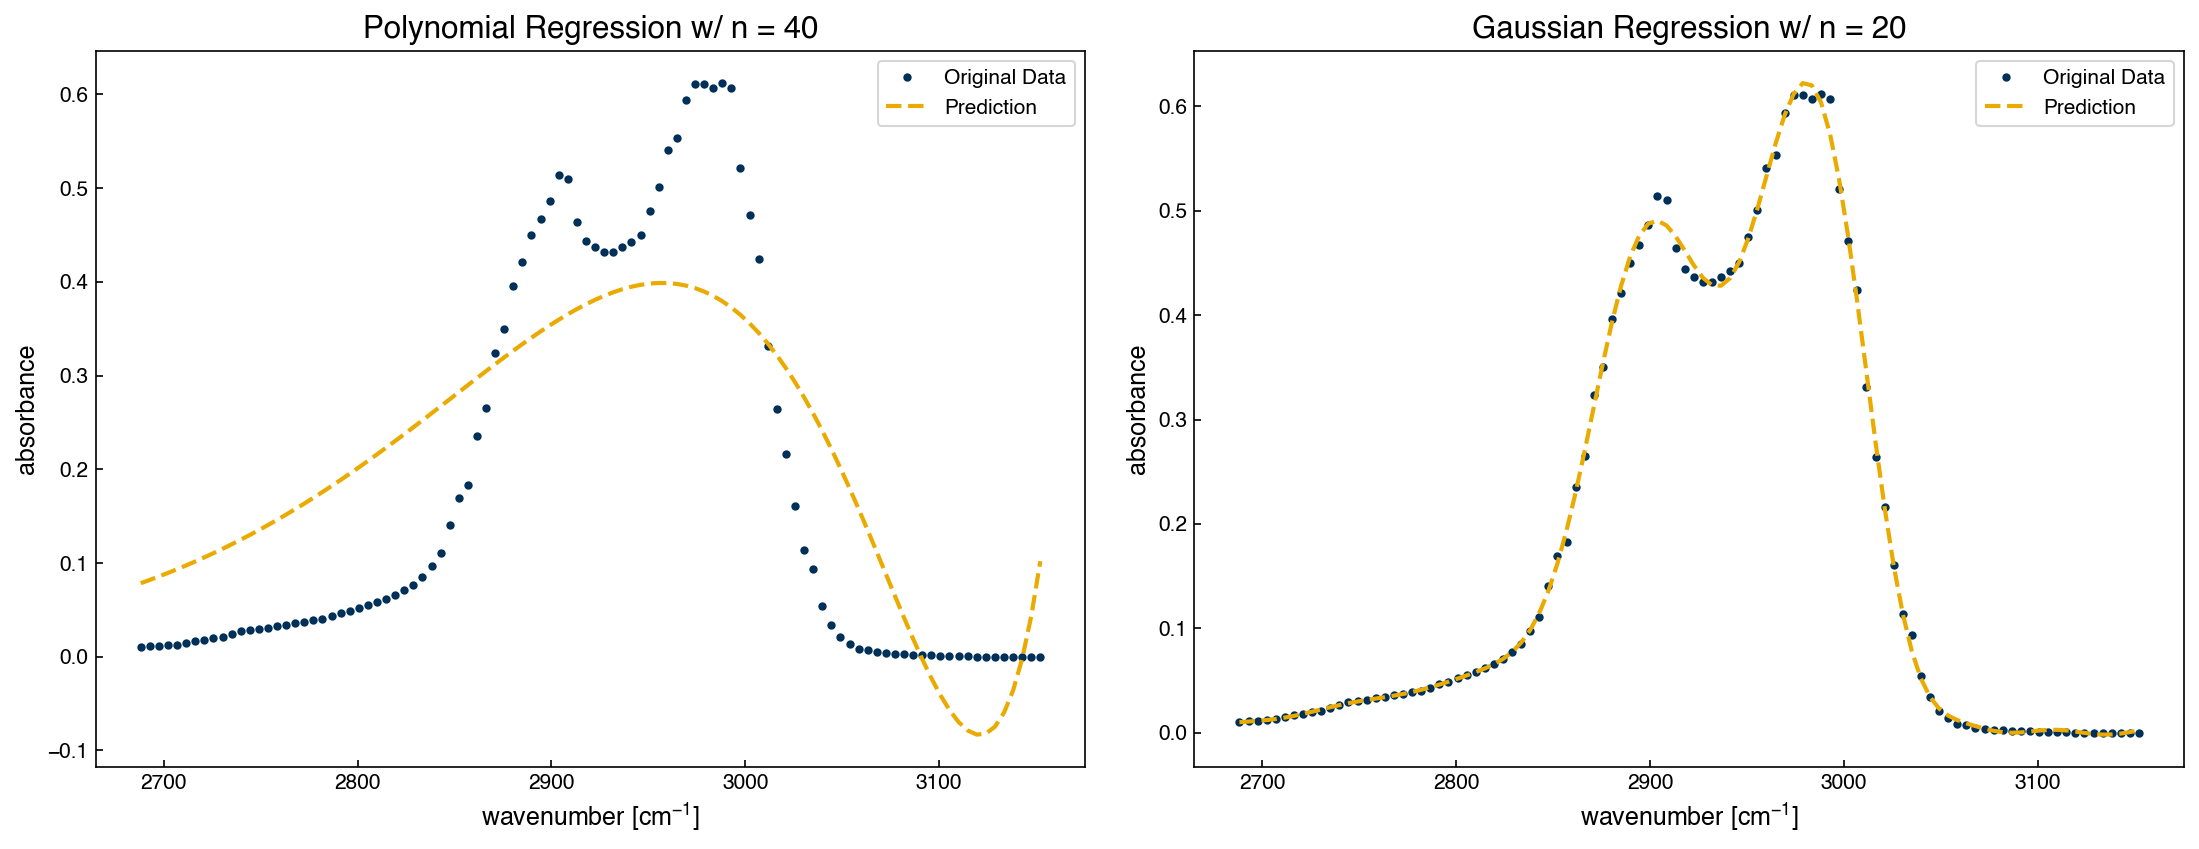

In [7]:
fig, axes = plt.subplots(1,2, figsize = (15, 6))
axes[0].plot(x_peak, y_peak, '.')
axes[1].plot(x_peak, y_peak, '.')

axes[0].plot(x_peak, yhat_poly, '--')
axes[1].plot(x_peak, yhat_gauss, '--')

for ax in axes:
    ax.set_xlabel('wavenumber [$cm^{-1}$]')
    ax.set_ylabel('absorbance')
    ax.legend(['Original Data', 'Prediction'])
    
axes[0].set_title('Polynomial Regression w/ n = 40')
axes[1].set_title('Gaussian Regression w/ n = 20');

Based on the visualization, it seems clear that the BIC prediction is correct: The Gaussian model is better even though it has fewer parameters.

Building on this, let's next use the BIC to determine the optimal number of evenly-spaced Gaussian basis functions. To do this, we compute the BIC as a function of *N* and choose the value that minimises the criterion.

Optimal N according to BIC = 15


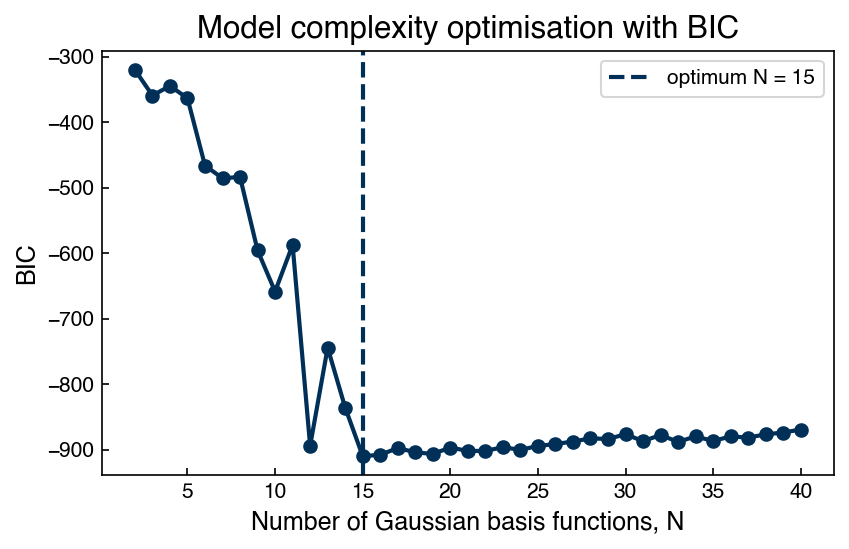

In [8]:
bic_list = []
N_list = range(2, 41)

for N in N_list:
    X = gaussian_features(x_peak, N)
    model = LinearRegression().fit(X, y_peak)
    yhat = model.predict(X)
    bic_list.append(BIC(y_peak, yhat, N))

opt_N = N_list[int(np.argmin(bic_list))]
print(f"Optimal N according to BIC = {opt_N}")

plt.figure(figsize=(6, 4))
plt.plot(N_list, bic_list, "o-" )
plt.xlabel("Number of Gaussian basis functions, N")
plt.ylabel("BIC")
plt.title("Model complexity optimisation with BIC")
plt.axvline(opt_N, ls="--", label=f"optimum N = {opt_N}")
plt.legend()

The two competing factors in complexity optimization can be seen in this plot. Before the optimum, the BIC decreases quickly because it is dominated by the improvement in accuracy. After the optimum, it increases slowly, because it is dominated by the logarithmic dependence on the number of parameters. Let's visualize again to see how the optimum from the BIC compares to models that it determined to be underfit or overfit:

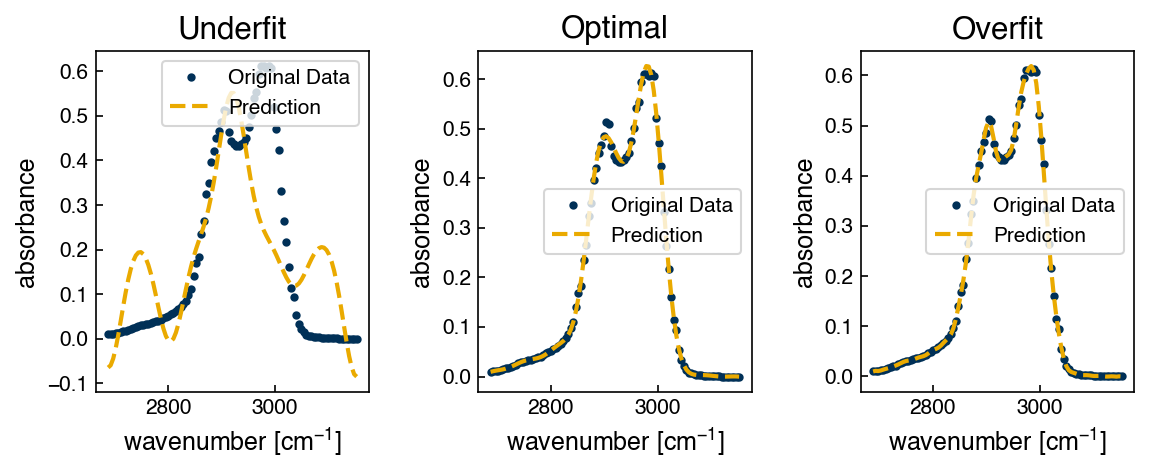

In [9]:
fig, axes = plt.subplots(1,3, figsize = (8, 3.5))
axes[0].plot(x_peak, y_peak, '.')
axes[1].plot(x_peak, y_peak, '.')
axes[2].plot(x_peak, y_peak, '.')

X_under = gaussian_features(x_peak, 5)
model_under = LinearRegression().fit(X_under, y_peak)
yhat_under = model_under.predict(X_under)
axes[0].plot(x_peak, yhat_under, '--')

X_opt = gaussian_features(x_peak, opt_N)
model_opt = LinearRegression().fit(X_opt, y_peak)
yhat_opt = model_opt.predict(X_opt)
axes[1].plot(x_peak, yhat_opt, '--')

X_over = gaussian_features(x_peak, 40)
model_over = LinearRegression().fit(X_over, y_peak)
yhat_over = model_over.predict(X_over)
axes[2].plot(x_peak, yhat_over, '--')

for ax in axes:
    ax.set_xlabel('wavenumber [$cm^{-1}$]')
    ax.set_ylabel('absorbance')
    ax.legend(['Original Data', 'Prediction'])
    
axes[0].set_title('Underfit')
axes[1].set_title('Optimal');
axes[2].set_title('Overfit');

The trend in BIC is reflected in the visualization here: the underfit model is very obviously much worse than the over-fit model. The over-fit model provides a very similar fit to the data, but it is less optimal because it has too many parameters.

```{note}
Using evenly-spaced Gaussians is not a very clever way to fit spectra, and would not be used in practice, but it serves as a useful demonstration of the concept of BIC and complexity optimization. Consider models that instead select peak positions and widths intuitively or using non-linear optimization. Do you expect that the BIC would be higher (less probable) or lower (more probable) than an evenly-spaced Gaussian model with the same number of fitted parameters?
```

### Additional Notes on Information Criteria

* **Effect of error distribution.**  If the residuals are far from normally distributed, the closed-form BIC above may be biased.  In that case you should compute the likelihood explicitly or use cross-validation.
* **Other information criteria.** There are numerous other information criteria such as the ["corrected AIC" (AICc)](https://doi.org/10.1093/biomet/76.2.297), the [Hannan–Quinn Information Criterion (HQIC)](https://www.jstor.org/stable/2985032), the [Deviance Information Criterion (DIC)](https://doi.org/10.1111/1467-9868.00353), and the [Minimum Description Length (MDL)](https://doi.org/10.1016/0005-1098(78)90005-5). In general, the BIC favors the simplest models, the AIC favors models with lower errors, and the others are in between. If you're unsure, try more than one and look for consensus. 
* **Information criteria vs. cross validation.** Information criteria are good options when you have small datasets or when you are comparing models with very similar forms. They tend to be very computationally inexpensive, but have more built-in statistical assumptions, and cannot easily be applied to non-parametric models. Cross validation is a more general approach, and works well when you have a lot of data or when you are comparing models with very different structures.

```{admonition} Exercise
Revisit the non-linear optimization examples from the numerical methods lectures and use the code to compare the BIC of non-linear optimization models with 1, 2, and 3 peaks to the BIC of the evenly-spaced Gaussians model above. Think carefully about how many fitted parameters there are in the case of non-linear regression!
```

## Regularization

Another way of controlling complexity is by trying to penalize models that change very sharply. This idea is called "regularization" and involves quantifying complexity by using parameters that penalize complexity -- models with large regularization parameters are expected to be less complicated. In general, regularization parameters are added to the loss function to reduce the magnitude of model weights. For example:

$$
L = \sum_i \epsilon_i^2 + \alpha \sqrt{\sum_j w_j^2}
$$

In this case, we introduce a new hyperparameter, $\alpha$, which controls the strength of regularization. We also choose to regularize on the square root of the sum of squared parameters, which is often called the **L2 norm** and written as:

$$
L = \sum_i \epsilon_i^2 + \alpha ||\vec{w}||_2
$$

We can also regularize in other ways, which can have advantages in some cases. We will discuss this more later, but will focus on the L2 norm for now.

---

```{note} Why does regularization promote "smooth" models?

The derivative of a model output $f$ with respect to an input feature often scales with the size of the fitting coefficients (you can easily verify this for linear regression!). Large coefficients therefore allow the model to wiggle sharply (large derivatives), whereas small coefficients restrict the curvature. Penalising the L2 norm of $\vec{w}$ thus encourages gentler slopes and a smoother function overall.
```

---

### Derivation of ridge regression

Regularization is especially critical for **non-parametric models**, where the number of parameters is often similar to or larger than the number of data points, and information criteria are not easily defined. It turns out that adding an $L_2$ penalty results in a relatively minor modification to the standard linear regression equations. Here, we briefly follow the linear regression derivation from the first module to show how this works out.

To start, we can expand the squared error loss function (using the same transpose rules as in the least-squares derivation):

$$
L = (\vec{y}-\bar{\bar{X}}\vec{w})^{T}(\vec{y}-\bar{\bar{X}}\vec{w}) + \alpha\vec{w}^{T}\vec{w}
$$

We can then refactor this expansion:

$$
L = \vec{w}^{T}\bar{\bar{X}}^{T}\bar{\bar{X}}\vec{w} - 2\vec{y}^{T}\bar{\bar{X}}\vec{w} + \vec{y}^{T}\vec{y} + \alpha\vec{w}^{T}\vec{w}
$$

Next we take the gradient with respect to $\vec{w}$ and set it to zero, as before:

$$
\nabla_{\vec{w}} L = 2\bar{\bar{X}}^{T}\bar{\bar{X}}\vec{w} - 2\bar{\bar{X}}^{T}\vec{y} + 2\alpha\vec{w} = \vec{0}
$$

Rearranging gives the **ridge normal equations**:

$$
\big(\bar{\bar{X}}^{T}\bar{\bar{X}} + \alpha\bar{\bar{I}}\big)\vec{w} = \bar{\bar{X}}^{T}\vec{y}
$$

Thus the penalty term adds a constant $\alpha$ to the diagonal of $\bar{\bar{X}}^{T}\bar{\bar{X}}$. This not only serves to penalize the magnitude of the weights, but it also improves conditioning and ensures invertibility for $\alpha>0$. It also does not add any computational cost, since the linear algebra operations are identical to linear regression.

```{note} 
If you aren't sure why adding a constant to the diagonal would ensure invertability, it may be worth revisiting the linear algebra section and thinking about the relationship between eigenvalues, condition numbers, and invertability.
```

Similar to what we have seen before, it is also possible to transform the features using a kernel, and the same basic math will hold. If we use a kernel and regularize on the sum of squared parameters we obtain **Kernel Ridge Regression (KRR)**, which is one of the most popular models in machine learning. KRR is relatively fast to train for small and medium ($ < $ 10K) datasets, and the fact that the training is well-conditioned and yields a unique solution makes it straightforward to apply in practice. For very large ($ > $1M) datasets, KRR (and most other non-parametric models) become impractical and it is necessary to use various approximations or switch to parametric models like neural networks.

Below we demonstrate KRR on the same ethanol IR peak used earlier.

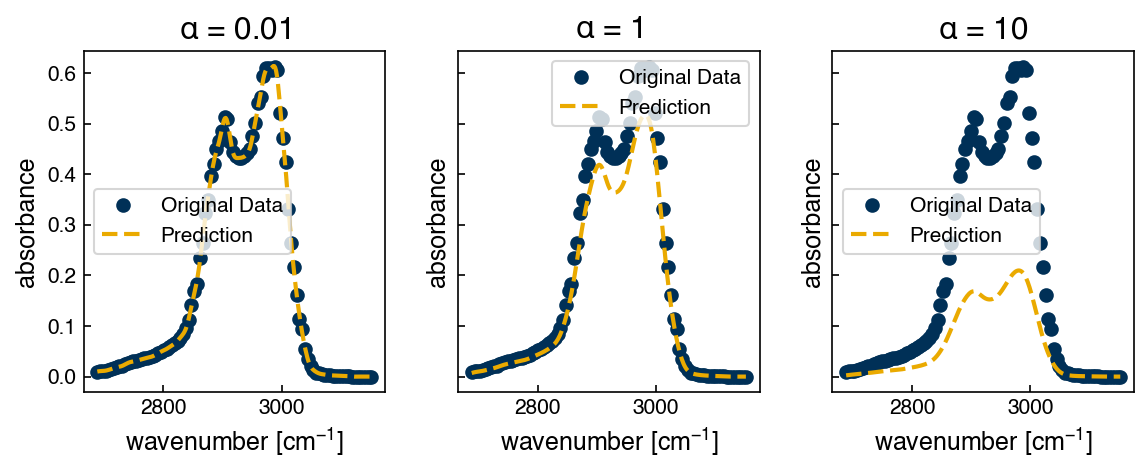

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

# Load and isolate the peak (same slice as before)
spec = pd.read_csv("data/ethanol_IR.csv")
x_all = spec['wavenumber [cm^-1]'].values.reshape(-1, 1)
y_all = spec['absorbance'].values.reshape(-1, 1)

x_peak = x_all[475:575]
y_peak = y_all[475:575]

sigma = 10
gamma = 1.0 / (2 * sigma ** 2)
alphas = [1e-2, 1, 10]
fig, axes = plt.subplots(1, 3, figsize=(8, 3.5), sharey=True)

for alpha, ax in zip(alphas, axes):

    KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
    KRR.fit(x_peak, y_peak)

    x_predict = np.linspace(x_peak.min(), x_peak.max(), 300).reshape(-1, 1)
    yhat_KRR = KRR.predict(x_predict)

    ax.plot(x_peak, y_peak, 'o')
    ax.plot(x_predict, yhat_KRR, '--', markerfacecolor='none')
    ax.set_xlabel('wavenumber [$cm^{-1}$]')
    ax.set_ylabel('absorbance')
    ax.legend(['Original Data', 'Prediction'])
    ax.set_title(r"$\alpha$ = {}".format(alpha))

Here we can see that increasing $\alpha$ makes the model more "smooth", and that if we increase it too far the model will not fit the data well. 

```{note} What happens as $\alpha \rightarrow 0$ and $\alpha \rightarrow \infty$?
* $\alpha \rightarrow 0$ removes the regularization term; the model can fit the training data almost perfectly because the number of parameters is equal to the number of data points (over-fitting).
* $\alpha \rightarrow \infty$ forces $\vec{w} \rightarrow 0$, collapsing the model toward a flat line (under-fitting).
```

### Selecting the optimal $\alpha$ using cross-validation

Cross validation is on of the most common and robust strategies for selecting hyperparameters like $\alpha$. In principle, any cross-validation strategy can be used to optimize hyperparameters, with different strategies having different trade-offs. Here we use a simple hold-out strategy by split the data once and treat 40 % as a hold-out set. We then scan $\alpha$ over four orders of magnitude.

Optimal alpha ≈ 1.17e-02


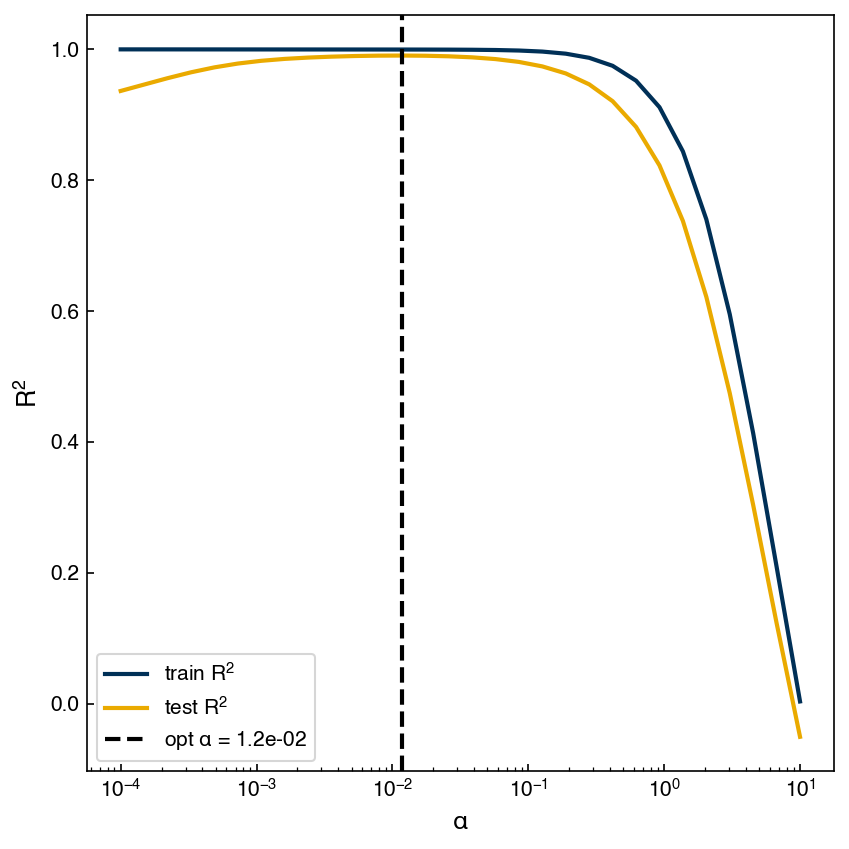

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

alphas = np.logspace(-4, 1, 30)
train_scores, test_scores = [], []

x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size=0.4, random_state=0)

for a in alphas:
    model = KernelRidge(alpha=a, kernel='rbf', gamma=gamma)
    model.fit(x_train, y_train)
    yhat_tr = model.predict(x_train)
    yhat_te = model.predict(x_test)
    train_scores.append(r2_score(y_train, yhat_tr))
    test_scores.append(r2_score(y_test, yhat_te))

opt_idx = int(np.argmax(test_scores))
opt_alpha = alphas[opt_idx]
print(f"Optimal alpha ≈ {opt_alpha:.2e}".format(opt_alpha))

fig, ax = plt.subplots(figsize=(6,6))
ax.semilogx(alphas, train_scores, label='train $R^2$')
ax.semilogx(alphas, test_scores, label='test $R^2$')
ax.axvline(opt_alpha, ls='--', color='k', label=r'opt $\alpha$ = {opt_alpha:.1e}'.format(opt_alpha=opt_alpha))
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('$R^2$')
ax.legend();

We see that the $r^2$ on the training set always increases as $\alpha$ decreases. However, the $r^2$ on the testing set starts to decrease as $\alpha \rightarrow 0$. This yields an optimum regularization strength. Note that the optimum is very broad -- the test $r^2$ is almost identical over nearly two orders of magnitude of $\alpha$. This tells us two things:

1) When searching for an optimum regularization strength, you should search over many orders of magnitude.
2) The exact value of the regularization strength is not very important. As long as you have a reasonable value, the results will be very similar.

---

### Inspecting parameter magnitudes with a histogram

In kernel ridge regression the fitted function can be written as a weighted sum over training points. Those **dual coefficients** act like parameters: stronger regularization (larger $\alpha$) shrinks many of them toward zero. Looking at their distribution is a quick way to see how much the model is relying on a few points versus spreading weight more evenly.

Number of training points: 100
Mean coeff: 3.418e-02, Std: 3.542e-01, L2 norm: 3.559e+00


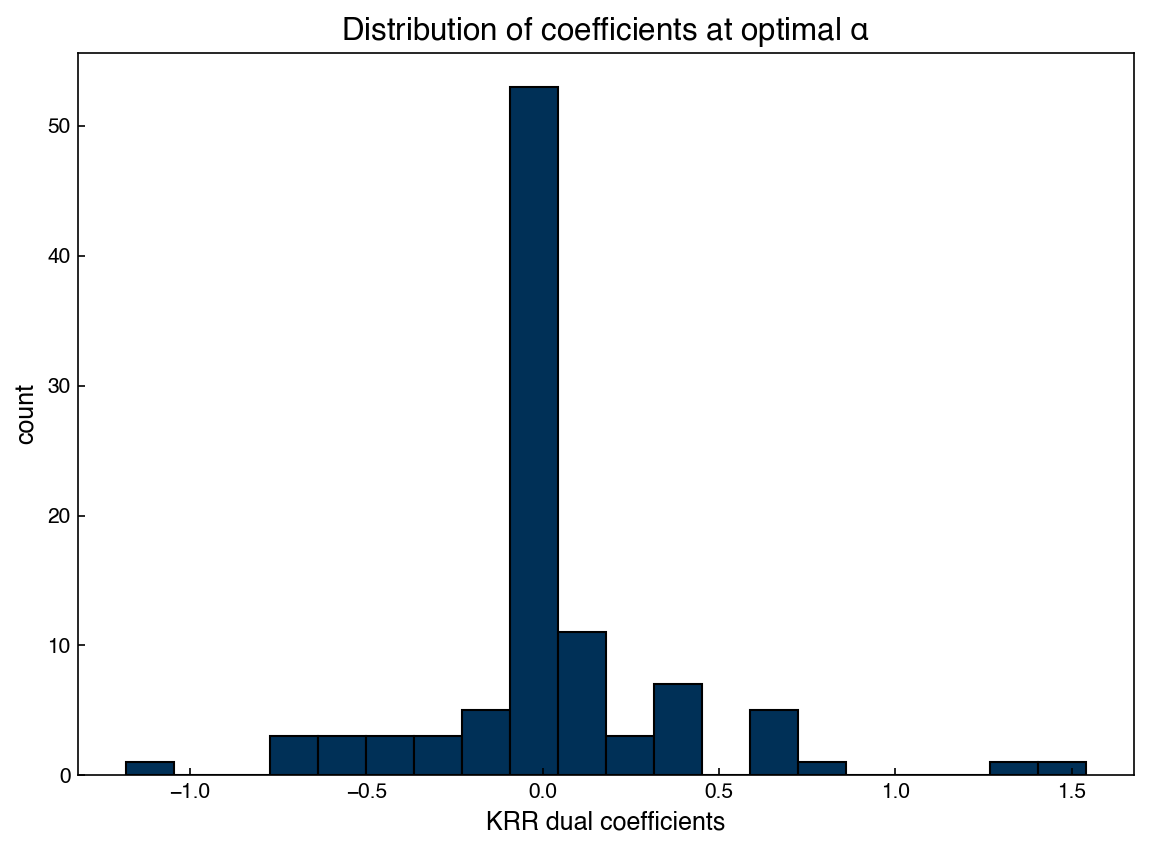

In [12]:
# Fit KRR on the full peak at the chosen opt_alpha and examine coefficients
model = KernelRidge(alpha=float(opt_alpha), kernel='rbf', gamma=gamma)
model.fit(x_peak, y_peak)

coeffs = np.ravel(model.dual_coef_)

fig, ax = plt.subplots()
ax.hist(coeffs, bins=20, edgecolor='k')
ax.set_xlabel('KRR dual coefficients')
ax.set_ylabel('count')
ax.set_title(r'Distribution of coefficients at optimal $\alpha$')

print(f"Number of training points: {coeffs.size}")
print(f"Mean coeff: {coeffs.mean():.3e}, Std: {coeffs.std():.3e}, L2 norm: {np.linalg.norm(coeffs):.3e}")

---

### LASSO Regularization


Ridge regression provides a good way to penalize model "smoothness", but it doesn't actually reduce the number of parameters. We can see that all of the coefficients are non-zero:

In [13]:
nonzero = [f for f in np.isclose(coeffs,0) if f == False]
print('Total number of non-zero parameters: {}'.format(len(nonzero)))

Total number of non-zero parameters: 100


Ideally we could also use regularization to reduce the number of parameters. It turns out that this can be achieved using the L1 norm:

$||L_1|| = \sum_i |w_i|$

where $|.|$ is the absolute value. This is called "least absolute shrinkage and selection operator" regression, which is a terrible name with a great acronym: LASSO. The loss function for LASSO is defined as:

$L_{LASSO} = \sum_i \epsilon_i^2 + \alpha ||\vec{w}||_1$

This can be compared to the loss function for ridge regression:

$L_{ridge} = \sum_i \epsilon_i^2 + \alpha ||\vec{w}||_2$

We will not go through the derivation of *why* the L1 norm causes parameters to go to zero, but the following schematic, borrowed from [this website](https://niallmartin.wordpress.com/2016/05/12/shrinkage-methods-ridge-and-lasso-regression/) may be useful (note that $\vec{\beta}$ is equivalent to $\vec{w}$. In short, the fact that the $L_1$ norm is square with points that fall on the axes makes it more likely that the combined loss function will have a minima that also falls on an axis (where one of the weights will be zero).

```{figure} images/lasso_vs_ridge_regression.png
:width: 600px
:align: center

Illustration of $L_1$ and $L_2$ loss functions used for regularization.
```

The derivation is much more complex, and the resulting model is slightly more difficult to solve, but the cost is generally similar to KRR. We can also test LASSO regression with `scikit-learn`. Unfortunately, we need to create our own feature (basis) matrix, $X_{ij}$, similar to linear regression, since "kernel LASSO" is not a very common approach. Usually, LASSO is applied directly to high-dimensional regression problems, as we will see later in the course.

To make a "kernel LASSO", we will need a function to evaluate the `rbf`. Instead of using our own, we can use the one from `scikit-learn`:

In [14]:
from sklearn.metrics.pairwise import rbf_kernel

sigma = 10
gamma = 1./(2*sigma**2)

X_train = rbf_kernel(x_train, x_train, gamma=gamma)

This is very similar to the functions we wrote before, but will generally be a little faster and more stable. Next we will integrate it with LASSO:

The number of coefficients: 60


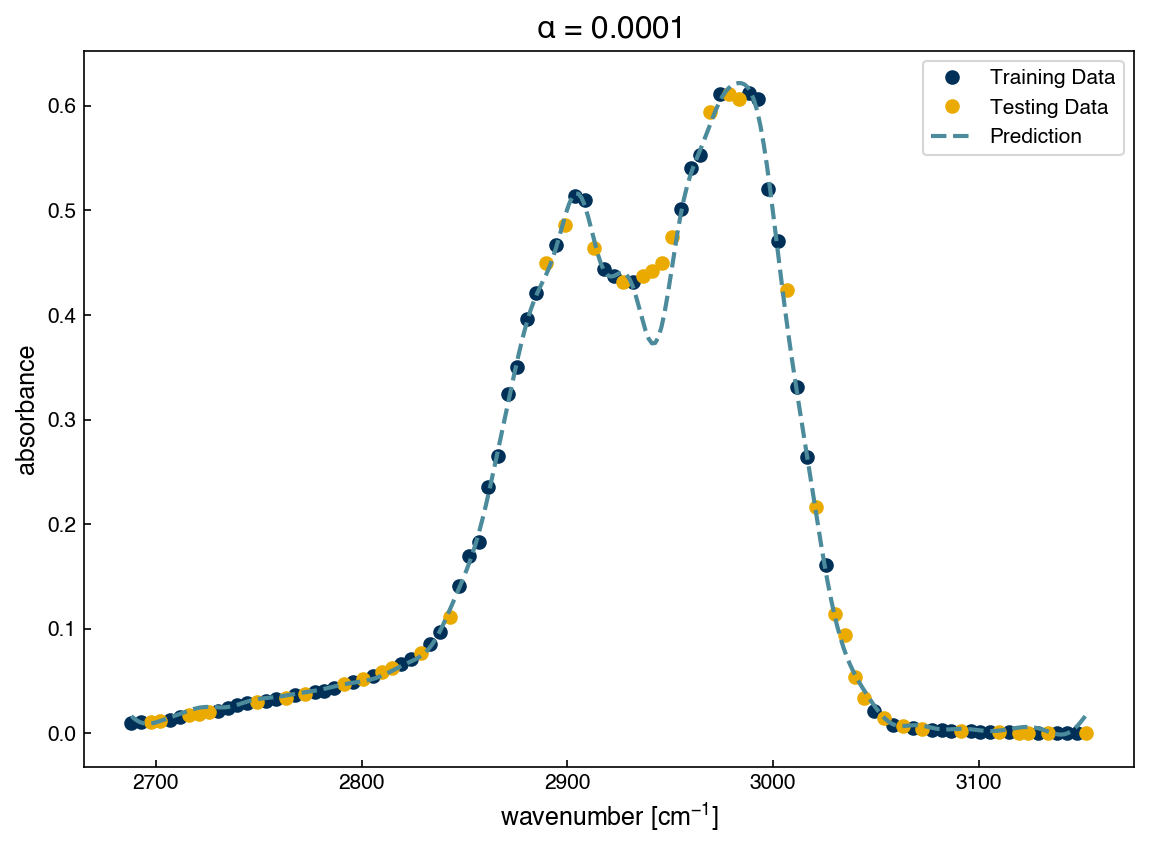

In [15]:
from sklearn.linear_model import Lasso

sigma = 10
gamma = 1./(2*sigma**2)

alpha = 1e-4

LASSO = Lasso(alpha=alpha)
LASSO.fit(X_train, y_train)
print('The number of coefficients: {}'.format(len(LASSO.coef_)))

x_predict = np.linspace(min(x_peak), max(x_peak), 300) #create prediction data
X_predict = rbf_kernel(x_predict, x_train, gamma=gamma)

yhat_LASSO = LASSO.predict(X_predict)

fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'o')
ax.plot(x_test, y_test, 'o')
ax.plot(x_predict, yhat_LASSO, '--')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.legend(['Training Data', 'Testing Data', 'Prediction'])
ax.set_title(r'$\alpha$ = {}'.format(alpha));

The results look similar to KRR. Now we can see how many non-zero parameters there are, and check the parameter values:

Total number of non-zero parameters: 41


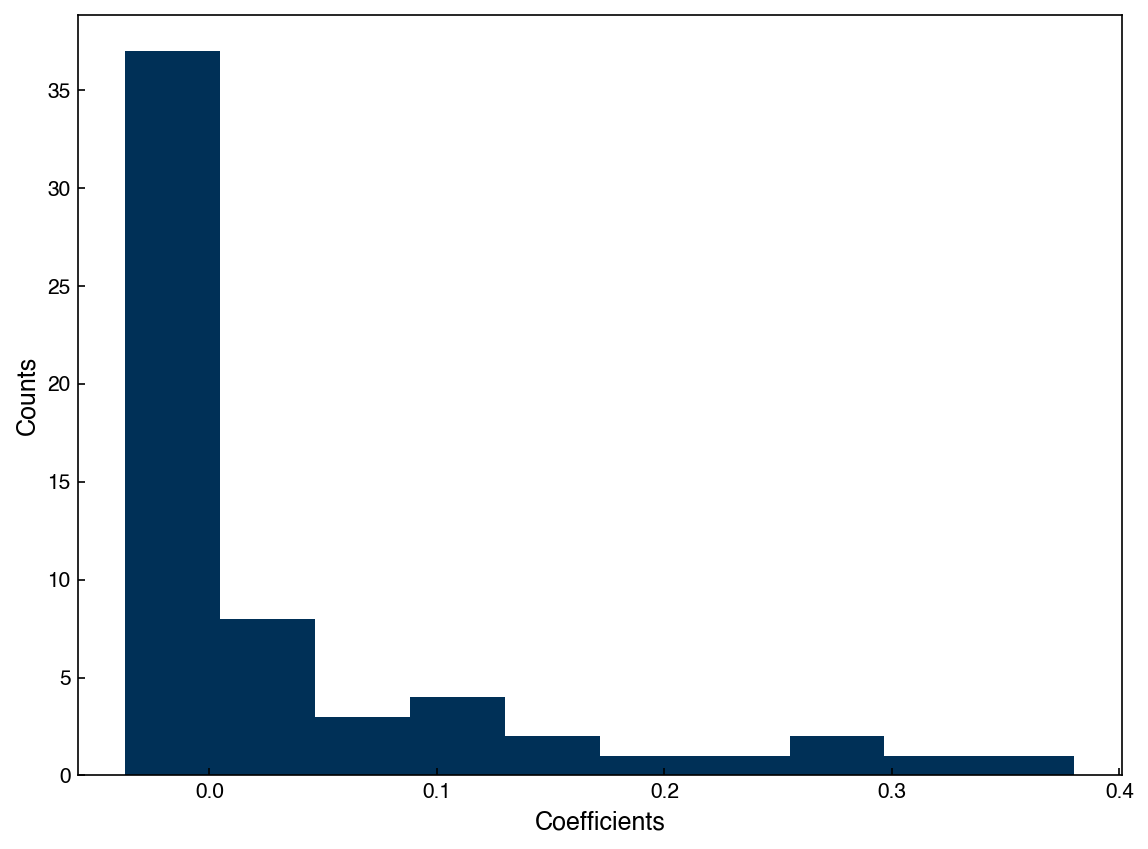

In [16]:
coeffs = LASSO.coef_

fig, ax = plt.subplots()
ax.hist(coeffs)
ax.set_xlabel('Coefficients')
ax.set_ylabel('Counts')

nonzero = [f for f in np.isclose(coeffs,0) if f == False]
print('Total number of non-zero parameters: {}'.format(len(nonzero)))

We see that the LASSO regularization has a lot of coefficients that are equal to zero. This is equivalent to discarding these terms and finding which Gaussians should (or should not) be included.

---

```{admonition} Exercise: compare KRR and LASSO
:class: tip
Using the same ethanol peak dataset:

1. **Build Gaussian-basis features** (reuse the same kernel width $\sigma$. Fit a **LASSO** model for a grid of $\alpha$ values and record test $r^2$.
2. **Fit KRR** on the same train/test split and $\alpha$ grid (keep $\sigma$ fixed) and record test $r^2$.
3. **Plot** test $r^2$ versus $\alpha$ for both models on one figure. At each model’s optimal $\alpha$, also **plot coefficient histograms**: LASSO weights and KRR dual coefficients.
```

## Hyperparameter tuning and data leakage

### Hyperparameter Tuning

The KRR and LASSO models above have 2 hyperparameters: $\gamma$ $\left(=\frac{1}{2\sigma^2}\right)$ and $\alpha$. So far, we have optimized $\alpha$, but the model performance (and optimal $\alpha$) will also depend on $\sigma$. You can probably see that optimizing these will get rather tedious.

Fortunately, `scikit-learn` has some nice built-in tools to help. The most commonly used is `GridSearchCV`, which is a brute-force approach that searches over a grid of hyperparameters, and uses cross-validation at each grid point to assess model performace.

Here we will use GridSearchCV to find the optimum KRR model and its score (related to $R^2$):

In [17]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Reuse x_peak, y_peak from above
x_train, x_test, y_train, y_test = train_test_split(x_peak, y_peak, test_size=0.4, random_state=0)

sigmas = np.array([5, 10, 15, 20, 25, 30, 35, 40])
gammas = 1.0/(2*sigmas**2)
alphas = np.array([1e-9, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0])

parameter_ranges = {'alpha': alphas, 'gamma': gammas}

KRR = KernelRidge(kernel='rbf')

KRR_search = GridSearchCV(KRR, parameter_ranges, cv=3, scoring='r2', refit=True)
KRR_search.fit(x_train, y_train.ravel())
KRR_search.best_estimator_, KRR_search.best_score_

(KernelRidge(alpha=np.float64(0.01), gamma=np.float64(0.0005555555555555556),
             kernel='rbf'),
 np.float64(0.9953287405139172))

This tells us that the best performance comes from a model with $\alpha=0.01$ and $\gamma=0.000555$. We can check the performance of the model:

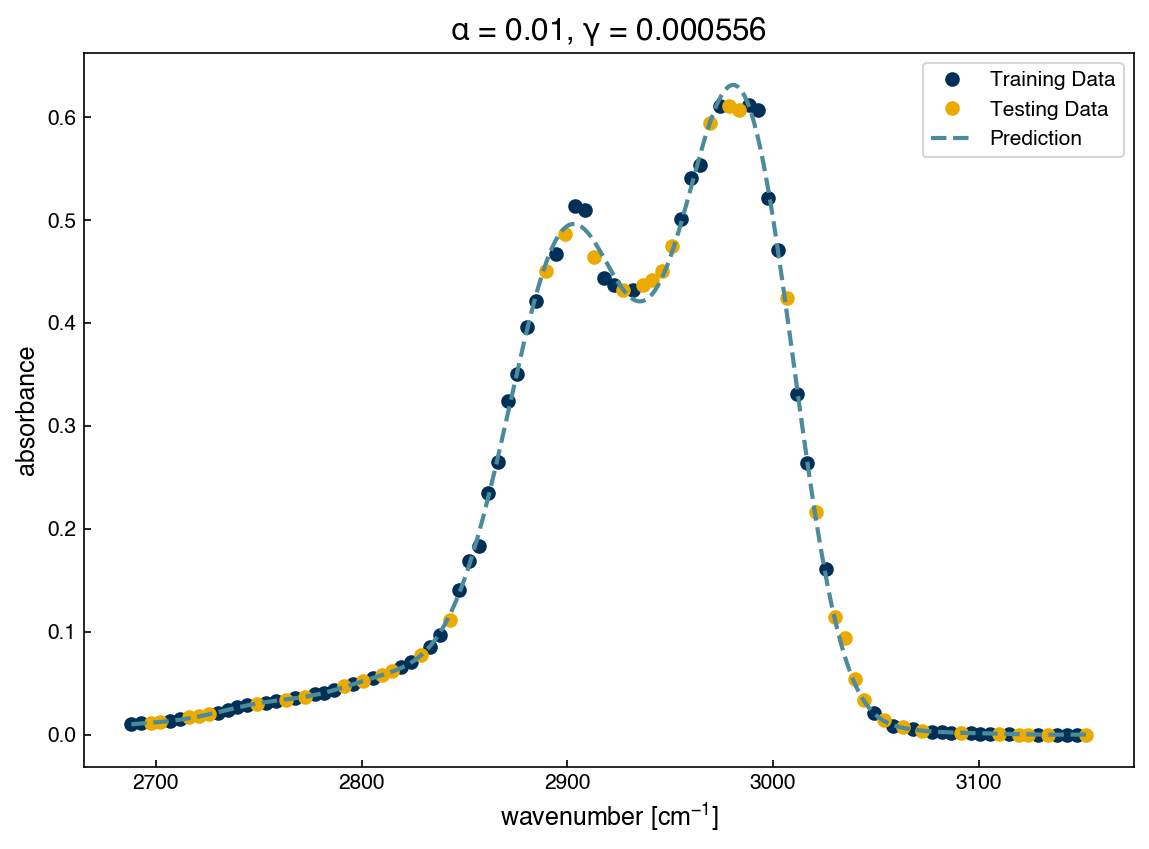

In [18]:
# Predict on a grid covering the peak
x_predict = np.linspace(x_peak.min(), x_peak.max(), 300).reshape(-1, 1)
yhat_KRR = KRR_search.best_estimator_.predict(x_predict)

fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'o')
ax.plot(x_test, y_test, 'o')
ax.plot(x_predict, yhat_KRR, '--', markerfacecolor='none')
ax.set_xlabel('wavenumber [$cm^{-1}$]')
ax.set_ylabel('absorbance')
ax.legend(['Training Data', 'Testing Data', 'Prediction'])
ax.set_title(r'$\alpha$ = {}, $\gamma$ = {:.6f}'.format(KRR_search.best_estimator_.alpha, KRR_search.best_estimator_.gamma));

This is much faster than doing all the work yourself! Remember that, ultimately, you want to evaluate the model on "validation" data that wasn't used in the hyperparameter tuning. This is done above: the `x_train` and `y_train` sets are used to optimize the hyperparameters (the cross validation splits happen inside the `fit` function) and the `x_test` and `y_test` are used as a *validation* set. If we want to evaluate the model performance, we should do so on the validation set **but we should not retrain the model parameters using the full or validation sets**.

In [19]:
r2_train = KRR_search.best_estimator_.score(x_train, y_train)
print(r'Training $r^2$ = {}'.format(r2_train))

r2_validation = KRR_search.best_estimator_.score(x_test, y_test)
print(r'Validation $r^2$ = {}'.format(r2_validation))

Training $r^2$ = 0.9987810785259702
Validation $r^2$ = 0.9986040494036984


We see that the results here are essentially identical, so this is a good validation that we do not have any over-fitting.

One note is that the best model, and the corresponding performance, will depend on the parameters you search over, as well as the cross-validation strategy, and sometimes even the random seed. In this case, `cv=3` means that the model performs 3-fold cross-validation at each gridpoint. If you change the settings and get slightly different results, don't worry too much. This usually just means that multiple hyperparameter settings yield similar results -- which you should be able to verify by comparing performance on the validation set. If you see that the validation performance is highly sensitive to cross validation strategy, that indicates that you may not have enough data.


### Practical Tips for Optimizing Hyperparameters

- **Start coarse, on a log scale.** For scale-sensitive params (e.g., α, γ), try 5–8 values spaced by orders of magnitude (for example, from 1e-6 to 1e0). For KRR, it is often convenient to grid **σ** and map to γ = 1/(2·σ²) since thinking about a standard deviation (σ) can be more intuitive than inverse width (γ).
- **Zoom in iteratively.** After the first search, build a **tighter grid centered on the best point** (halve/double neighboring values). Repeat until the improvement between rounds is negligible.
- **Do not accept an "edge" optimum.** If the best score occurs at the **minimum or maximum** of any grid axis, **expand that axis** and re-run. Reporting an edge value is a red flag that the true optimum lies outside the search.
- **Remember that parameters may be coupled.** Some parameters trade off with each other (e.g., KRR’s α and γ). When zooming in, refine **both** around the current best.
- **Beware of computational time.** If you are trying to optimize many parameters, start with `RandomizedSearchCV` (broad, cheap), then finish with a small `GridSearchCV` around the most promising region.
- **Reproducibility.** If you want the results to be reproducible, fix the `random_state` for splits and record the grid you tried alongside the selected hyperparameters.

```{admonition} Terminology around "test" and "validation" sets.
:class: warning

One key idea in machine learning is that you ultimately want to evaluate the model on data that it hasn't seen at all. When you use data for tuning hyperparameters, this counts as "seeing" the data, since it was used to set the model up. Unfortunately, there is a major ambiguity in the literature about what to call these different sets:

In older statistics books and the notes for this course "test" sets are used to optimize hyperparameters and "validation" sets are totally unseen datasets used for a final model evaluation. I personally find this intuitive: test sets are used to test out different possible settings, and a validation set is used in the end to validate the model.

However, the general modern consensus seems to be the opposite: "validation" sets are used to optimize hyperparameters and "test" sets are totally unseen by the model or hyperparameter optimization. Similarly, ambiguous naming may appear in variable naming due to convenience (e.g. `x_test` above is used as a validation set).

In any of your work, you may use either convention, but **you must clearly explain which convention you are using** in any reports or discussion of your results. This is good practice, since even in the current literature you will find both conventions used.
```

### Data Leakage

When performing cross validation, it is important to be aware of "data leakage", which occurs when information from the validation set (which is supposed to be totally unseen) is inadvertantly used in model construction. There are a few ways this can happen:

1. Hyperparameter optimization: Once data has been used to optimize the hyperparameters of a model, the model is biased toward that data. The distinction between "testing" and "validation" sets is meant to address this form of data leakage. If you want the most reliable evaluation of how your model will perform on new data, you should use the performance on the *validation* set that is not used in any way in hyperparameter tuning.

2. Feature scaling: This will be discussed more in subsequent lectures, but is is common practice to "rescale" model inputs to give them consistent units before putting them into a regression or classification model. If the testing or validation data is used to scale the data, then information has leaked in. Sometimes the effect is subtle, but sometimes it is very significant (especially with time series or stratified splits).

3. Data-specific Subtleties: There are problem-specific ways that information can flow between the training and testing sets. One example is if the target data is derived from some underlying source that is used to generate both the training and testing sets. A specific example is chemical reaction energies, which are derived from the formation energies of individual species. If the formation energy of a given molecule appears in reactions that are present in both the training and the testing set, then the model can implicitly learn the energy from the training data. Sometimes, this may be okay (e.g. if your goal is only to predict reactions that all share the same molecules), but other times it may give misleading results (e.g. if your goal is to predict new reactions based on unseen molecules). For a more detailed example of how training and testing domains can be complicated in chemistry and chemical engineering, consider the various definitions of "in domain" and "out of domain" data from the [Open Catalyst Project dataset and models](https://pubs.acs.org/doi/10.1021/acscatal.0c04525).

While there are some concrete things not to do (don't use validation data in hyperparameter tuning, and don't use testing/validation data to scale features) there is no single specific way to avoid data leakage. Instead, the following general idea is recommended: think carefully about how you want to apply your model in practice, then ensure that the *validation data is generated to be as close as possible to the real use case.* In an ideal scenario, this means that you create your validation dataset *after the model is trained*, but this is often impractical. The next best thing is to consider how the data was generated, and "hide" some of the original raw data from the entire modeling pipeline (e.g. store it in a different folder on your computer until after the model is trained). It is often very surprising how different the performance of a model can be between "testing" and "validation" sets, and a large discrepancy

---

```{admonition} Exercise: Evaluating data leakage
:class: tip
Using the ethanol peak dataset:

1. **Split** the data into **train (70%)** and **validation (30%)** sets.
2. **Tune hyperparameters** with `GridSearchCV` **using only the training set** (e.g., KRR over $\\alpha$ and $\\gamma$). Record the **best CV score** and the **validation $R^2$** when evaluating the refit model on the validation set.
3. **Compare** the **validation $R^2$** with the best $R^2$ found during the `GridSearchCV` (e.g. `best_score_`). 
4. **Evaluate** the impact of data leakage by incorrectly re-training the model on the full dataset, then re-evaluate the $R^2$ score on the validation set.
```

## Additional reading

- {cite}`hastie09` — *The Elements of Statistical Learning*, Ch. 3 (linear methods, regularization) and Ch. 7 (model assessment and selection).
- {cite}`tibshirani1996lasso` — The original LASSO paper.
- {cite}`hoerl1970ridge` — Ridge regression (L2) introduction.
- [Kaggle blog post on data leakage](https://www.kaggle.com/code/dansbecker/data-leakage/notebook)